# Duds During Darden's Duration:
## Anomaly Detection in Access Logs
#### Kwame V. Taylor

Project Description Here.

Info on cohorts can be found in ```cohorts.csv```.

### Imports

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

# default viz size settings
plt.rc('figure', figsize=(14, 9))
plt.rc('font', size=15)

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

# importing GeoIP database for IP geolocation
import geoip2.database
reader = geoip2.database.Reader('GeoLite2City/GeoLite2-City.mmdb')

# import system to check types of errors
import sys

from wrangle import acquire_access_logs, prepare_logs
from preprocessing import add_network_and_host, add_city, add_country
from explore import plot_top_cities, plot_city_anomalies, plot_top_countries

### Acquire

In [2]:
colnames = ['date', 'timestamp', 'request_method', 'user_id', 'cohort_id', 'ip']

df = pd.read_csv('anonymized-curriculum-access.txt', header=None, index_col=False,
                 names=colnames, delim_whitespace=True, na_values='"-"')
#                 usecols=[0, 1, 2, 5])
df.head()

,date,timestamp,request_method,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22,97.105.19.61


### Prepare

In [4]:
# merge date and timestamp
df["ds"] = df["date"] +" "+ df["timestamp"]
df.head()

,date,timestamp,request_method,user_id,cohort_id,ip,ds
0,2018-01-26,09:55:03,/,1,8,97.105.19.61,2018-01-26 09:55:03
1,2018-01-26,09:56:02,java-ii,1,8,97.105.19.61,2018-01-26 09:56:02
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,2018-01-26 09:56:05
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,2018-01-26 09:56:06
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22,97.105.19.61,2018-01-26 09:56:24


In [5]:
# drop date and timestamp
df = df.drop(columns=['date', 'timestamp'])
df.head()

,request_method,user_id,cohort_id,ip,ds
0,/,1,8,97.105.19.61,2018-01-26 09:55:03
1,java-ii,1,8,97.105.19.61,2018-01-26 09:56:02
2,java-ii/object-oriented-programming,1,8,97.105.19.61,2018-01-26 09:56:05
3,slides/object_oriented_programming,1,8,97.105.19.61,2018-01-26 09:56:06
4,javascript-i/conditionals,2,22,97.105.19.61,2018-01-26 09:56:24


In [6]:
# convert date column to datetime type
df.ds = pd.to_datetime(df.ds)
df.dtypes

request_method            object
user_id                    int64
cohort_id                 object
ip                        object
ds                datetime64[ns]
dtype: object

In [7]:
# set ds as index and sort
# this is a very important step!
df = df.set_index('ds').sort_index()
df.head()

,request_method,user_id,cohort_id,ip
ds,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61


In [8]:
df.shape

(719459, 4)

In [9]:
df.request_method.value_counts()

/                                                    40122
search/search_index.json                             15393
javascript-i                                         14551
toc                                                  14018
java-iii                                             10835
                                                     ...  
6-regression/8-Project                                   1
content/appendix/javascript/functions/models.html        1
npm                                                      1
examples/css/..%255c                                     1
appendix/offer-letters                                   1
Name: request_method, Length: 2154, dtype: int64

In [10]:
df.ip.value_counts()

97.105.19.58       268648
97.105.19.61        60530
192.171.117.210      8896
71.150.217.33        4919
12.106.208.194       4262
                    ...  
172.58.109.108          1
71.78.157.46            1
107.77.219.19           1
172.56.6.31             1
173.239.232.28          1
Name: ip, Length: 4064, dtype: int64

In [11]:
df.cohort_id.nunique()

386

Some IP addresses accidentally got put in the ```cohort_id``` column, so I'm going to drop those rows.

In [12]:
df = df.drop(df[df.cohort_id.str.len() > 4].index)
df

,request_method,user_id,cohort_id,ip
ds,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61
...,...,...,...,...
2020-11-02 16:48:13,javascript-i/coffee-project,763,62,107.192.148.199
2020-11-02 16:48:17,javascript-i/mapbox-api,771,62,172.125.226.175
2020-11-02 16:48:18,javascript-i/coffee-project,771,62,172.125.226.175


**Drop nulls**

In [13]:
df.isna().sum()

request_method      0
user_id             0
cohort_id         420
ip                  0
dtype: int64

In [14]:
df = df.dropna()

I noticed there are some requests that are just ```/```. I believe this is when the main page is accessed. I'm going to drop them.

**Drop bad request_methods**

In [15]:
# there are over 10,000 of these '/' requests
df.groupby(['request_method']).filter(lambda x : len(x)>10000).head(3)

,request_method,user_id,cohort_id,ip
ds,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61
2018-01-26 10:00:37,/,6,22,97.105.19.61
2018-01-26 10:00:39,javascript-i,6,22,97.105.19.61


In [16]:
df = df.drop(df[df.request_method.str.len() < 2].index)
df.head()

,request_method,user_id,cohort_id,ip
ds,,,,
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61
2018-01-26 09:56:41,javascript-i/loops,2,22,97.105.19.61


**Split IP address into network and host**
 * **Reference**: https://docs.oracle.com/cd/E19504-01/802-5753/planning3-18471/index.html

In [17]:
df[['network1','network2', 'host1', 'host2']] = df.ip.str.split(".",expand=True)
df.head()

,request_method,user_id,cohort_id,ip,network1,network2,host1,host2
ds,,,,,,,,
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,97,105,19,61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,97,105,19,61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,97,105,19,61
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,97,105,19,61
2018-01-26 09:56:41,javascript-i/loops,2,22,97.105.19.61,97,105,19,61


In [18]:
df['network'] = df['network1'] + df['network2']
df['host'] = df['host1'] + df['host2']
df.head()

,request_method,user_id,cohort_id,ip,network1,network2,host1,host2,network,host
ds,,,,,,,,,,
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,97,105,19,61,97105,1961
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,97,105,19,61,97105,1961
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,97,105,19,61,97105,1961
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,97,105,19,61,97105,1961
2018-01-26 09:56:41,javascript-i/loops,2,22,97.105.19.61,97,105,19,61,97105,1961


**I notice that there is at least one instance of a different user_id under the same exact IP address. Might be a typo, or just something I don't understand about IP addresses.**

In [19]:
df = df.drop(columns=['network1', 'network2', 'host1', 'host2'])
df.head()

,request_method,user_id,cohort_id,ip,network,host
ds,,,,,,
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,97105,1961
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,97105,1961
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,97105,1961
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,97105,1961
2018-01-26 09:56:41,javascript-i/loops,2,22,97.105.19.61,97105,1961


In [20]:
df.network.nunique()

700

In [21]:
df.host.nunique()

3727

### Explore & Feature Engineering

In [22]:
# create dataframe out of value counts
ip_counts = pd.DataFrame(df.ip.value_counts()).reset_index()

# rename columns
ip_counts.columns=['ip', 'event_count']

# get the number of ip addresses seen 1, or 2, or 11,998 times. 
ip_counts.groupby(['event_count']).count()

,ip
event_count,
1,537
2,511
3,313
4,238
5,184
...,...
4077,1
4590,1
8447,1


In [23]:
# pass the entropy function an array-like object of counts. 
entropy(ip_counts.event_count)

4.149481083203116

**Make darden_df for just dates from Darden cohort**

In [24]:
df.tail(2)

,request_method,user_id,cohort_id,ip,network,host
ds,,,,,,
2020-11-02 16:48:28,javascript-i/bom-and-dom/bom,771,62,172.125.226.175,172125,226175
2020-11-02 16:48:47,javascript-i/bom-and-dom/bom,763,62,107.192.148.199,107192,148199


In [25]:
darden_df = df.loc['2020-07-13':'2020-11-02']
darden_df.head(2)

,request_method,user_id,cohort_id,ip,network,host
ds,,,,,,
2020-07-13 00:00:19,appendix,633,57,24.26.242.224,2426,242224
2020-07-13 00:00:23,appendix/professional-development/linkedin-tips,633,57,24.26.242.224,2426,242224


In [26]:
darden_df.shape

(98631, 6)

### Geolocation Exploration

**Add City Feature**

In [27]:
def add_city(ip):
    try:
        response = reader.city(ip)
        city_name = response.city.name
        return city_name
    except:
        return np.nan

In [28]:
darden_df['city'] = darden_df.apply(lambda darden_df: add_city(darden_df['ip']),axis=1)

In [29]:
darden_df.head()

,request_method,user_id,cohort_id,ip,network,host,city
ds,,,,,,,
2020-07-13 00:00:19,appendix,633,57,24.26.242.224,2426,242224,San Antonio
2020-07-13 00:00:23,appendix/professional-development/linkedin-tips,633,57,24.26.242.224,2426,242224,San Antonio
2020-07-13 00:04:59,appendix/professional-development/cover-letter,614,56,174.67.1.123,17467,1123,Oklahoma City
2020-07-13 00:05:49,spring/fundamentals/security/authentication,606,56,76.187.7.114,76187,7114,Garland
2020-07-13 00:52:09,javascript-i/arrays,672,58,67.11.50.23,6711,5023,Boerne


In [30]:
darden_df.city.nunique()

105

In [31]:
darden_df.city.value_counts()

San Antonio      68077
Dallas            5451
Boerne            3315
New Braunfels     1966
Austin            1491
                 ...  
Whittier             1
Floresville          1
Bulverde             1
Pflugerville         1
Marfa                1
Name: city, Length: 105, dtype: int64

In [32]:
darden_df.shape

(98631, 7)

In [260]:
city_plot_df = darden_df.groupby('city').filter(lambda x : len(x)>900)
city_plot_df.city.nunique()

11

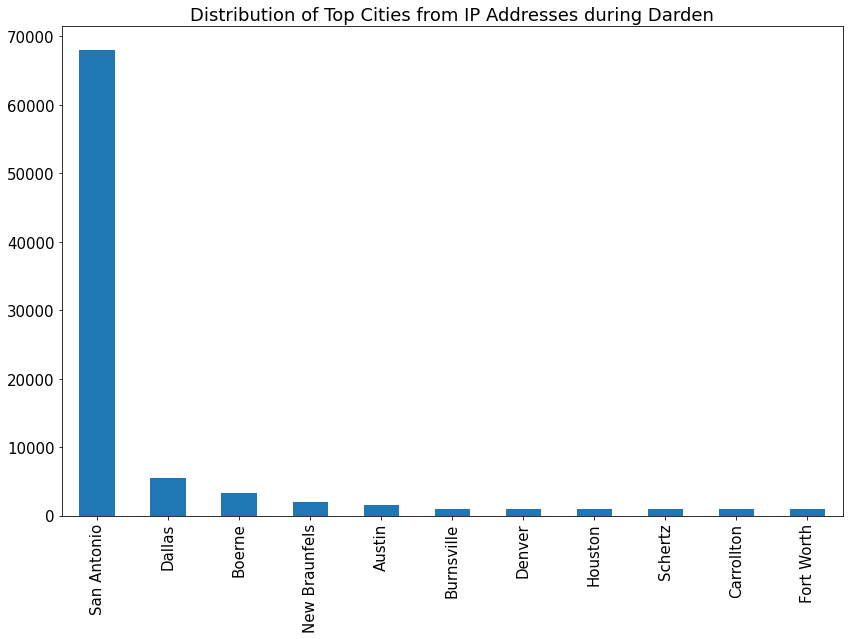

In [34]:
city_plot_df['city'].value_counts().plot(kind='bar')
plt.title('Distribution of Top Cities from IP Addresses during Darden')
plt.show()

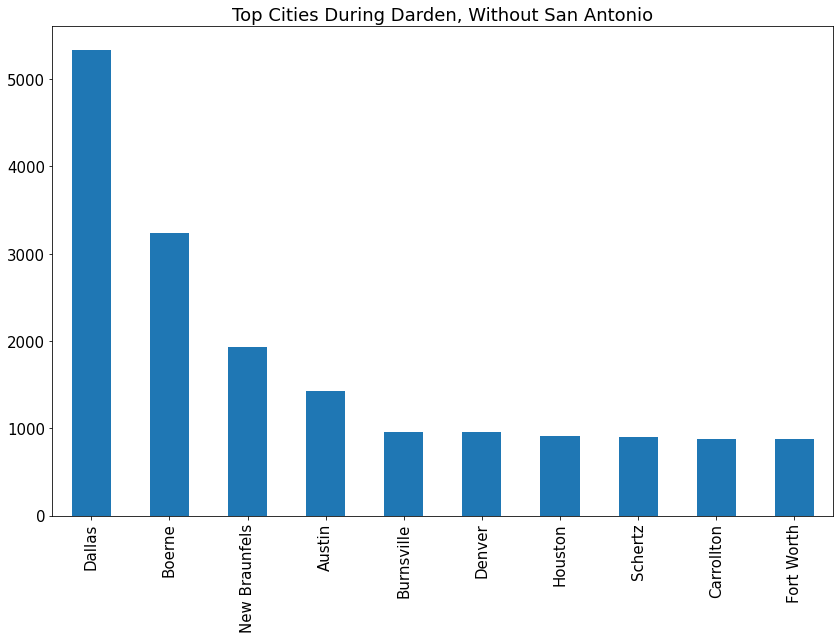

In [35]:
city_plot_df['city'].drop(city_plot_df[city_plot_df.city == 'San Antonio'].index).value_counts().plot(kind='bar')
plt.title('Top Cities During Darden, Without San Antonio')
plt.show()

In [36]:
city_plot_anomalies = darden_df.groupby('city').filter(lambda x : len(x)<4)
city_plot_anomalies.city.nunique()

20

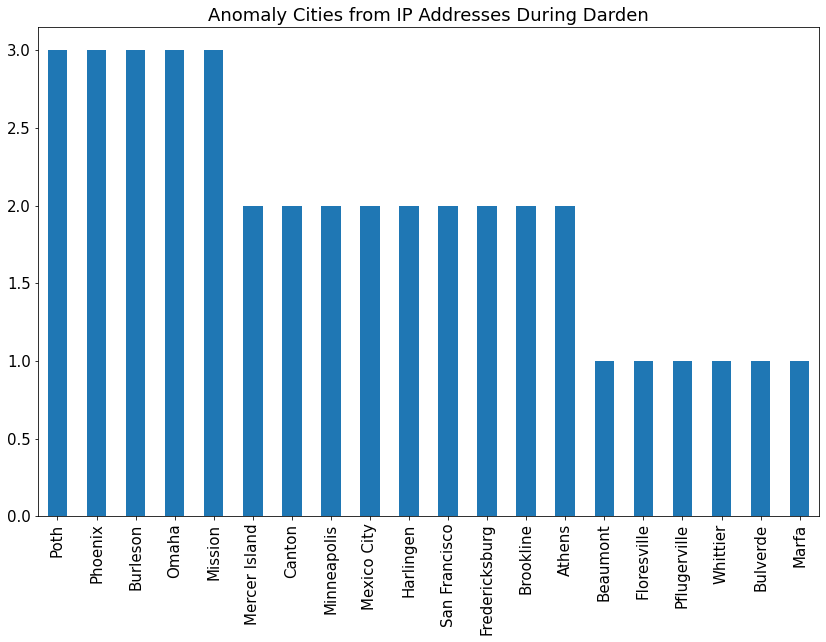

In [37]:
city_plot_anomalies['city'].value_counts().plot(kind='bar')
plt.title('Anomaly Cities from IP Addresses During Darden')
plt.show()

**Takeaways:** Mexico City showed up (it seems GeoLite couldn't acquire the city in some places and gave me the country instead), so I'm going to see if I can zoom in on geolocations from outside the USA.

**Create Country feature**

Note: Still working with just the Darden duration data so that my geolocation code isn't too computationally expensive.

In [38]:
def add_country(ip):
    try:
        response = reader.city(ip)
        country_name = response.country.name
        return country_name
    except:
        return np.nan

In [39]:
darden_df['country'] = darden_df.apply(lambda darden_df: add_country(darden_df['ip']),axis=1)

In [40]:
darden_df.country.nunique()
darden_df.country.value_counts()
country_plot_df = darden_df.groupby('country').filter(lambda x : len(x)>700)
country_plot_df.country.nunique()

1

In [41]:
darden_df.head()

,request_method,user_id,cohort_id,ip,network,host,city,country
ds,,,,,,,,
2020-07-13 00:00:19,appendix,633,57,24.26.242.224,2426,242224,San Antonio,United States
2020-07-13 00:00:23,appendix/professional-development/linkedin-tips,633,57,24.26.242.224,2426,242224,San Antonio,United States
2020-07-13 00:04:59,appendix/professional-development/cover-letter,614,56,174.67.1.123,17467,1123,Oklahoma City,United States
2020-07-13 00:05:49,spring/fundamentals/security/authentication,606,56,76.187.7.114,76187,7114,Garland,United States
2020-07-13 00:52:09,javascript-i/arrays,672,58,67.11.50.23,6711,5023,Boerne,United States


**Look for Suspicious IPs in the City and Country NaNs**

It's possible that the city for some IP addresses was unable to be acquired because of suspicious reasons. 

There are hits from Germany, U.S. Virgin Islands, and Mexico.

Let's investigate.

Reference: https://ipremoval.sms.symantec.com/ipr/lookup

I tested the reference with my own IP address for a quick check of it's validity, and it came back with "no bad reputation" for my IP address.

In [42]:
darden_df[darden_df.country != 'United States'].country.value_counts()

Germany                81
U.S. Virgin Islands     4
Mexico                  2
Name: country, dtype: int64

In [43]:
darden_df[darden_df.country == 'Germany'].ip.value_counts()

79.220.63.16      62
87.158.135.133    19
Name: ip, dtype: int64

> The IP Address 79.220.63.16 was found to have a negative reputation. Reasons for this assessment include:
> * The host has been observed sending spam in a format that is similar to snow shoe spamming techniques.
> * The host is unauthorized to send email directly to email servers.

> The IP Address 87.158.135.133 was found to have a negative reputation. Reasons for this assessment include:
> * The host has been observed sending spam in a format that is similar to snow shoe spamming techniques.
> * The host is unauthorized to send email directly to email servers.

**Create bad IPs dataframe**

In [44]:
#add these to bad ips df
bad_ips = darden_df[(darden_df.ip == '79.220.63.16') | 
                    (darden_df.ip == '79.220.63.16')]
bad_ips

,request_method,user_id,cohort_id,ip,network,host,city,country
ds,,,,,,,,
2020-10-05 09:02:56,javascript-ii,12,22,79.220.63.16,79220,6316,Munich,Germany
2020-10-05 09:03:04,javascript-i,12,22,79.220.63.16,79220,6316,Munich,Germany
2020-10-05 09:03:08,javascript-i/introduction,12,22,79.220.63.16,79220,6316,Munich,Germany
2020-10-05 09:03:12,javascript-i/introduction/primitive-types,12,22,79.220.63.16,79220,6316,Munich,Germany
2020-10-05 09:03:16,javascript-i/introduction/operators,12,22,79.220.63.16,79220,6316,Munich,Germany
...,...,...,...,...,...,...,...,...
2020-10-05 09:08:16,java-ii/file-io,12,22,79.220.63.16,79220,6316,Munich,Germany
2020-10-05 09:08:19,java-ii/dependency-management,12,22,79.220.63.16,79220,6316,Munich,Germany
2020-10-05 09:08:24,java-ii/junit-tdd,12,22,79.220.63.16,79220,6316,Munich,Germany


In [45]:
darden_df.isna().sum()

request_method      0
user_id             0
cohort_id           0
ip                  0
network             0
host                0
city              185
country             0
dtype: int64

In [46]:
darden_df[darden_df.city.isna()]

,request_method,user_id,cohort_id,ip,network,host,city,country
ds,,,,,,,,
2020-07-13 10:14:49,spring/fundamentals/views,615,56,107.242.125.32,107242,12532,None,United States
2020-07-13 11:19:32,html-css/elements,615,56,107.242.125.32,107242,12532,None,United States
2020-07-13 11:19:46,html-css/forms,615,56,107.242.125.32,107242,12532,None,United States
2020-07-13 11:20:03,html-css/css-i,615,56,107.242.125.32,107242,12532,None,United States
2020-07-13 11:20:04,html-css/css-i/introduction,615,56,107.242.125.32,107242,12532,None,United States
...,...,...,...,...,...,...,...,...
2020-11-02 13:33:07,jquery,769,62,98.39.66.72,9839,6672,None,United States
2020-11-02 13:33:12,javascript-i,769,62,98.39.66.72,9839,6672,None,United States
2020-11-02 13:33:16,javascript-i/bom-and-dom,769,62,98.39.66.72,9839,6672,None,United States


**Takeaways:** Using https://ipremoval.sms.symantec.com/ipr/lookup, I searched for ```107.242.125.32``` and it returned:

>The IP Address 107.242.125.32 was found to have a negative reputation. Reasons for this assessment include:
>* The host has been observed sending spam in a format that is similar to snow shoe spamming techniques.
>* The host is unauthorized to send email directly to email servers.

I ran IP address ```98.39.66.72``` as well, but it did not have any bad reputation.

Regardless, I see that both of those IP addresses seem to hit each page quickly, in succession.

**I can conclude that these two IP addresses are scrapper bots.**

The scrapper bots seem to maybe be scrapping the Web Dev curriculum more than the Data Science curriculum, so I'm going to run a hypothesis test to test that. However, first I need to prepare the data for the test.

In [47]:
darden_df[darden_df.city.isna()].ip.value_counts()

107.242.125.32     26
98.39.66.72        22
107.77.201.165     21
174.128.181.39     19
170.130.2.251      16
31.13.189.90        9
107.152.98.82       8
174.246.201.223     8
107.242.125.50      7
12.31.71.58         7
107.242.125.38      5
208.30.107.160      4
174.255.132.117     4
206.214.78.211      4
174.246.196.212     4
176.113.73.30       3
107.158.15.51       3
3.209.254.178       3
107.242.125.63      2
72.173.98.235       2
206.214.78.35       2
174.128.180.196     1
107.158.15.59       1
174.244.67.71       1
107.77.201.138      1
107.77.201.226      1
107.242.125.44      1
Name: ip, dtype: int64

I've also found that ```107.77.201.165```, ```174.128.181.39```, ```170.130.2.251```, ```174.246.201.223```,  have bad reputations according to the search as well.

I wonder if 107 at the beginning of an IP address means something important.

For ```170.130.2.251```, ```31.13.189.90```, ```107.152.98.82``` the search results included another reason for the bad reputation - snow shoe spamming.

Turn out that ```12.31.71.58 ```, ```206.214.78.35``` and ```3.209.254.178 ``` are not even valid IPv4 addresses.

Now that's enough manual lookup. Time to move on. I'll just store my proven suspicious IPs in a new dataframe named ```bad_ips```.

**Add to bad IPs dataframe**

In [183]:
bad_ips_append = darden_df[(darden_df.ip == '107.77.201.165') | 
                    (darden_df.ip == '174.128.181.39') | 
                    (darden_df.ip == '170.130.2.251') | 
                    (darden_df.ip == '174.246.201.223') | 
                    (darden_df.ip == '170.130.2.251') | 
                    (darden_df.ip == '31.13.189.90') | 
                    (darden_df.ip == '107.152.98.82')]
bad_ips = pd.merge(bad_ips, bad_ips_append, how='outer')
bad_ips

,request_method,user_id,cohort_id,ip,network,host,city,country
0,javascript-ii,12,22,79.220.63.16,79220,6316,Munich,Germany
1,javascript-ii,12,22,79.220.63.16,79220,6316,Munich,Germany
2,javascript-i,12,22,79.220.63.16,79220,6316,Munich,Germany
3,javascript-i/introduction,12,22,79.220.63.16,79220,6316,Munich,Germany
4,javascript-i/introduction/primitive-types,12,22,79.220.63.16,79220,6316,Munich,Germany
...,...,...,...,...,...,...,...,...
138,javascript-i/loops,127,23,174.128.181.39,174128,18139,None,United States
139,javascript-i/arrays,127,23,174.128.181.39,174128,18139,None,United States
140,javascript-i/arrays/manipulating,127,23,174.128.181.39,174128,18139,None,United States
141,javascript-i/coffee-project,127,23,174.128.181.39,174128,18139,None,United States


## Where am I?

In [51]:
kwame_df = df[df.ip == '99.132.128.255']
kwame_df

,request_method,user_id,cohort_id,ip,network,host
ds,,,,,,
2020-07-14 16:08:28,1-fundamentals/1.3-pipeline-demo,687,59,99.132.128.255,99132,128255
2020-07-14 16:09:31,1-fundamentals/1.1-intro-to-data-science,687,59,99.132.128.255,99132,128255
2020-07-14 16:09:32,1-fundamentals/modern-data-scientist.jpg,687,59,99.132.128.255,99132,128255
2020-07-14 16:09:32,1-fundamentals/AI-ML-DL-timeline.jpg,687,59,99.132.128.255,99132,128255
2020-07-14 16:32:47,1-fundamentals/1.2-data-science-pipeline,687,59,99.132.128.255,99132,128255
...,...,...,...,...,...,...
2020-10-31 16:45:54,timeseries/modeling-lesson1,780,59,99.132.128.255,99132,128255
2020-11-02 09:21:45,anomaly-detection/overview,780,59,99.132.128.255,99132,128255
2020-11-02 09:21:45,anomaly-detection/AnomalyDetectionCartoon.jpeg,780,59,99.132.128.255,99132,128255


In [54]:
darden_students.city.value_counts()

San Antonio      16831
Burnsville         986
Austin             899
Boerne             788
Houston            411
Helotes            111
Converse            55
Marble Falls        48
Hondo               37
Port Aransas        20
Dallas              20
Raleigh             17
New Braunfels       16
Killeen              7
Cibolo               6
Phoenix              3
Omaha                3
Harlingen            2
Minneapolis          2
Beaumont             1
Marfa                1
Tulsa                1
Name: city, dtype: int64

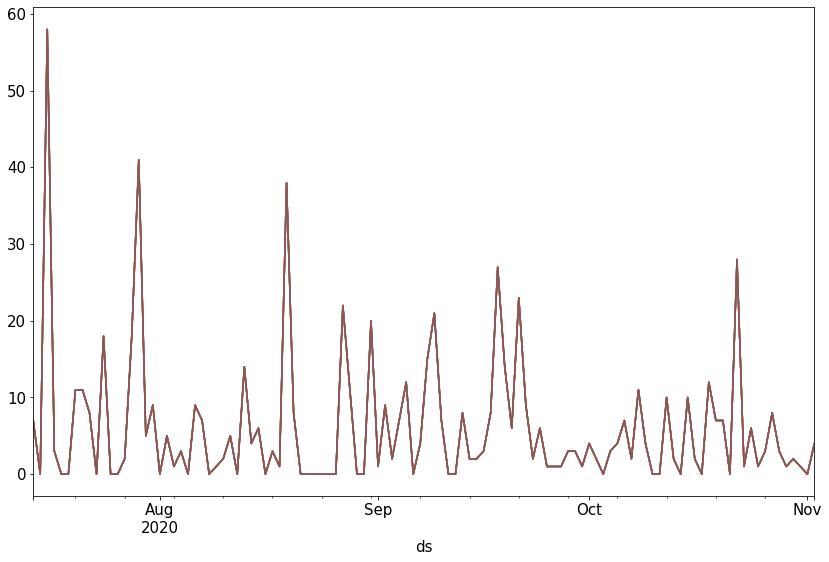

In [55]:
kwame_df.resample('D').count().plot(legend=False)

In [56]:
response = reader.city('99.132.128.255')
print(response.location.latitude)
print(response.location.longitude)

29.4059
-98.5078


Close, but not super precise.

### Slice data by cohort/program

In [57]:
#program_id == 2
web_dev = df[(df.cohort_id == '15') | 
             (df.cohort_id == '16') | 
             (df.cohort_id == '18') | 
             (df.cohort_id == '20') | 
             (df.cohort_id == '21') | 
             (df.cohort_id == '22') | 
             (df.cohort_id == '23') | 
             (df.cohort_id == '24') | 
             (df.cohort_id == '25') | 
             (df.cohort_id == '26') | 
             (df.cohort_id == '27') | 
             (df.cohort_id == '28') | 
             (df.cohort_id == '29') | 
             (df.cohort_id == '31') | 
             (df.cohort_id == '32') | 
             (df.cohort_id == '33') | 
             (df.cohort_id == '51') | 
             (df.cohort_id == '52') | 
             (df.cohort_id == '53') | 
             (df.cohort_id == '56') | 
             (df.cohort_id == '57') | 
             (df.cohort_id == '58') | 
             (df.cohort_id == '60') | 
             (df.cohort_id == '61') | 
             (df.cohort_id == '62') | 
             (df.cohort_id == '132')]

#program_id == 3
data_science = df[(df.cohort_id == '30') | 
                  (df.cohort_id == '34') | 
                  (df.cohort_id == '55') | 
                  (df.cohort_id == '59')]

### Add city and country and state features

In [157]:
data_science['city'] = data_science.apply(lambda data_science: add_city(data_science['ip']),axis=1)
data_science['country'] = data_science.apply(lambda data_science: add_country(data_science['ip']),axis=1)
data_science.head(3)

,request_method,user_id,cohort_id,ip,network,host,city,country
ds,,,,,,,,
2019-08-20 09:40:28,3-sql/1-mysql-overview,470,34,97.105.19.58,97105,1958,Dallas,United States
2019-08-20 09:40:50,appendix/cli-git-overview,479,34,97.105.19.58,97105,1958,Dallas,United States
2019-08-20 09:41:02,1-fundamentals/1.1-intro-to-data-science,469,34,97.105.19.58,97105,1958,Dallas,United States
2019-08-20 09:41:02,1-fundamentals/modern-data-scientist.jpg,469,34,97.105.19.58,97105,1958,Dallas,United States
2019-08-20 09:41:02,1-fundamentals/AI-ML-DL-timeline.jpg,469,34,97.105.19.58,97105,1958,Dallas,United States
2019-08-20 09:41:28,1-fundamentals/1.1-intro-to-data-science,480,34,97.105.19.58,97105,1958,Dallas,United States
2019-08-20 09:41:28,1-fundamentals/AI-ML-DL-timeline.jpg,480,34,97.105.19.58,97105,1958,Dallas,United States
2019-08-20 09:41:28,1-fundamentals/modern-data-scientist.jpg,480,34,97.105.19.58,97105,1958,Dallas,United States
2019-08-20 09:41:36,1-fundamentals/1.1-intro-to-data-science,482,34,97.105.19.58,97105,1958,Dallas,United States


In [188]:
web_dev['city'] = web_dev.apply(lambda web_dev: add_city(web_dev['ip']),axis=1)
web_dev['country'] = web_dev.apply(lambda web_dev: add_country(web_dev['ip']),axis=1)
web_dev.head(3)

,request_method,user_id,cohort_id,ip,network,host,city,country
ds,,,,,,,,
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,97105,1961,Dallas,United States
2018-01-26 09:56:41,javascript-i/loops,2,22,97.105.19.61,97105,1961,Dallas,United States
2018-01-26 09:56:46,javascript-i/conditionals,3,22,97.105.19.61,97105,1961,Dallas,United States
2018-01-26 09:56:48,javascript-i/functions,3,22,97.105.19.61,97105,1961,Dallas,United States
2018-01-26 09:56:59,javascript-i/loops,2,22,97.105.19.61,97105,1961,Dallas,United States
2018-01-26 09:58:26,javascript-i/functions,4,22,97.105.19.61,97105,1961,Dallas,United States
2018-01-26 09:59:22,mkdocs/search_index.json,5,22,97.105.19.61,97105,1961,Dallas,United States
2018-01-26 10:00:02,javascript-i/introduction/working-with-data-ty...,6,22,97.105.19.61,97105,1961,Dallas,United States
2018-01-26 10:00:39,javascript-i,6,22,97.105.19.61,97105,1961,Dallas,United States


In [54]:
darden_students.city.value_counts()

San Antonio      16831
Burnsville         986
Austin             899
Boerne             788
Houston            411
Helotes            111
Converse            55
Marble Falls        48
Hondo               37
Port Aransas        20
Dallas              20
Raleigh             17
New Braunfels       16
Killeen              7
Cibolo               6
Phoenix              3
Omaha                3
Harlingen            2
Minneapolis          2
Beaumont             1
Marfa                1
Tulsa                1
Name: city, dtype: int64

### Add state feature

In [204]:
def add_state(ip):
    try:
        response = reader.city(ip)
        state_name = response.subdivisions.most_specific.name
        return state_name
    except:
        return np.nan

In [205]:
data_science['state'] = data_science.apply(lambda data_science: add_state(data_science['ip']),axis=1)
web_dev['state'] = web_dev.apply(lambda web_dev: add_state(web_dev['ip']),axis=1)
data_science.head(12)

,request_method,user_id,cohort_id,ip,network,host,city,country,state
ds,,,,,,,,,
2019-08-20 09:40:28,3-sql/1-mysql-overview,470,34,97.105.19.58,97105,1958,Dallas,United States,Texas
2019-08-20 09:40:50,appendix/cli-git-overview,479,34,97.105.19.58,97105,1958,Dallas,United States,Texas
2019-08-20 09:41:02,1-fundamentals/1.1-intro-to-data-science,469,34,97.105.19.58,97105,1958,Dallas,United States,Texas
2019-08-20 09:41:02,1-fundamentals/modern-data-scientist.jpg,469,34,97.105.19.58,97105,1958,Dallas,United States,Texas
2019-08-20 09:41:02,1-fundamentals/AI-ML-DL-timeline.jpg,469,34,97.105.19.58,97105,1958,Dallas,United States,Texas
2019-08-20 09:41:28,1-fundamentals/1.1-intro-to-data-science,480,34,97.105.19.58,97105,1958,Dallas,United States,Texas
2019-08-20 09:41:28,1-fundamentals/AI-ML-DL-timeline.jpg,480,34,97.105.19.58,97105,1958,Dallas,United States,Texas
2019-08-20 09:41:28,1-fundamentals/modern-data-scientist.jpg,480,34,97.105.19.58,97105,1958,Dallas,United States,Texas
2019-08-20 09:41:36,1-fundamentals/1.1-intro-to-data-science,482,34,97.105.19.58,97105,1958,Dallas,United States,Texas


**Quick visualization**

In [234]:
plot_df = data_science.groupby('city').filter(lambda x : len(x)>100)
plot_df.city.nunique()

16

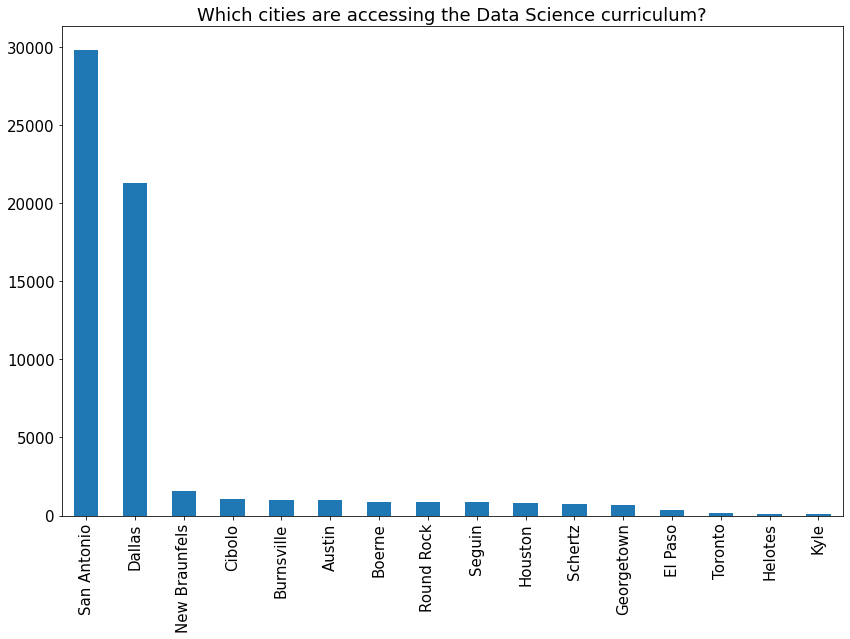

In [235]:
plot_df['city'].value_counts().plot(kind='bar')
plt.title('Which cities are accessing the Data Science curriculum?')
plt.show()

In [198]:
plot_df = web_dev.groupby('city').filter(lambda x : len(x)>900)
plot_df.city.nunique()

23

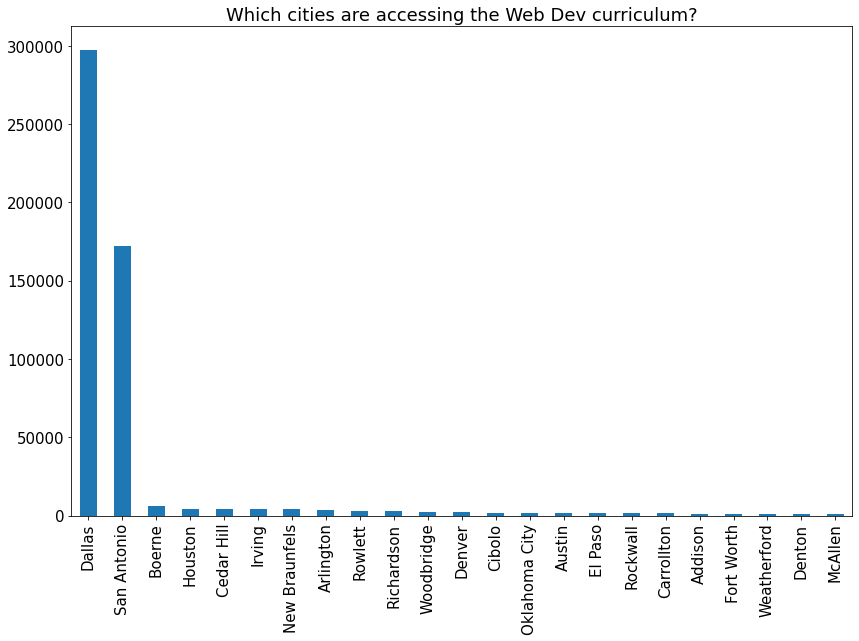

In [200]:
plot_df['city'].value_counts().plot(kind='bar')
plt.title('Which cities are accessing the Web Dev curriculum?')
plt.show()

In [255]:
plot_df = data_science.groupby('state').filter(lambda x : len(x)>0)
plot_df.state.nunique()

18

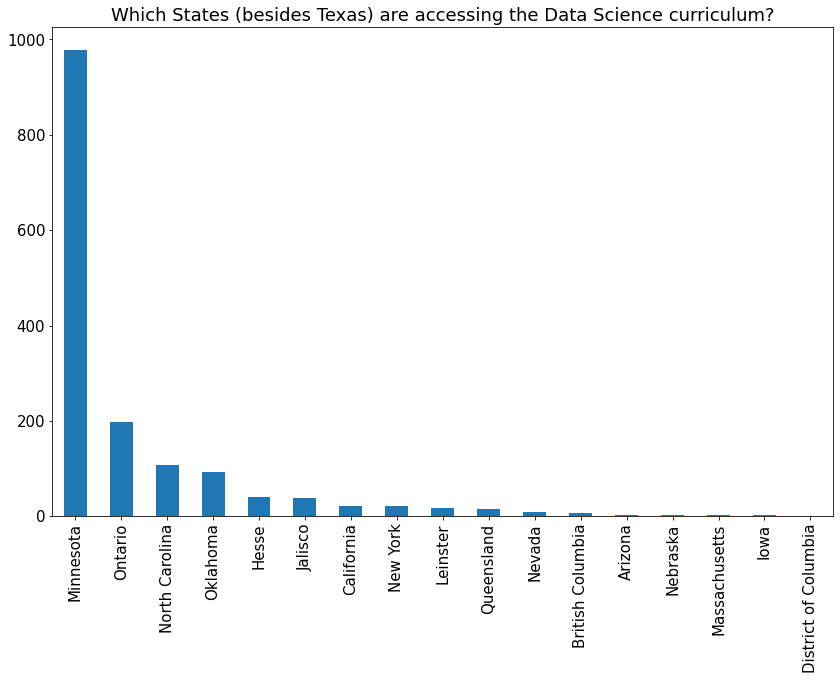

In [257]:
plot_df['state'].drop(plot_df[plot_df.state == 'Texas'].index).value_counts().plot(kind='bar')
plt.title('Which States (besides Texas) are accessing the Data Science curriculum?')
plt.show()

### Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [58]:
data_science.request_method.value_counts()

1-fundamentals/modern-data-scientist.jpg                  1559
1-fundamentals/AI-ML-DL-timeline.jpg                      1553
1-fundamentals/1.1-intro-to-data-science                  1530
search/search_index.json                                  1329
6-regression/1-overview                                   1122
                                                          ... 
7-classification/confusion-matrix                            1
A-clustering/project                                         1
regression/ridge-regression                                  1
spring/extra-features/error-pages/asdfasdf                   1
anomaly-detection/time-series-anomaly-detection-part-1       1
Name: request_method, Length: 595, dtype: int64

**Takeaway:** The most popular lesson for Data Science cohorts is Fundamentals (1.1): Intro to Data Science. Second to that is Regression: Overview.

In [59]:
web_dev.request_method.value_counts()

toc                                                      13161
javascript-i                                             13112
search/search_index.json                                 12107
java-iii                                                 10083
html-css                                                  9768
                                                         ...  
00_                                                          1
curie-python-assessment.html                                 1
content/php_iv/classes-and-objects-ii/overriding.html        1
9_Anomaly_Detection                                          1
extra-features/json-response                                 1
Name: request_method, Length: 1798, dtype: int64

**Takeaway:** The most popular lesson for Web Dev cohorts is TOC (not sure if that's actually a lesson or not), which has just a handful of hits more than the second most popular lesson, Javascript I.

### Is there a cohort that referred to a lesson significantly more that other cohorts seemed to gloss over? 

In [60]:
# data science cohorts
cohorts = ['30', '34', '55', '59']
for cohort in cohorts:
    print('Five most popular lessons in cohort', cohort + ':\n')
    print(data_science[data_science.cohort_id == cohort].request_method.value_counts().head(5))
    print('\n---\n')

Five most popular lessons in cohort 30:

Series([], Name: request_method, dtype: int64)

---

Five most popular lessons in cohort 34:

1-fundamentals/modern-data-scientist.jpg    625
1-fundamentals/AI-ML-DL-timeline.jpg        623
1-fundamentals/1.1-intro-to-data-science    613
search/search_index.json                    550
6-regression/1-overview                     521
Name: request_method, dtype: int64

---

Five most popular lessons in cohort 55:

6-regression/1-overview                     594
search/search_index.json                    479
1-fundamentals/modern-data-scientist.jpg    467
1-fundamentals/AI-ML-DL-timeline.jpg        464
1-fundamentals/1.1-intro-to-data-science    460
Name: request_method, dtype: int64

---

Five most popular lessons in cohort 59:

classification/overview                     756
classification/scale_features_or_not.svg    587
sql/mysql-overview                          510
1-fundamentals/modern-data-scientist.jpg    467
1-fundamentals/AI-ML-DL-timel

Cohort 30 (Ada) seems to not have accessed this curriculum, or the information is missing.

Bayes' most popular lessons were in Fundamentals and Regression.

Curie's were Regression and Fundamentals (in that order).

Darden's are (so far) Classification, SQL, and Fundamentals.


**Takeaways:** Everyone looks at fundamentals a lot, Curie and Bayes both look at Regression a lot, and Darden is a bit different. We also use the search feature relatively less than previous cohorts.

### Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students? 

In [158]:
for cohort in cohorts:
    print('Cohort', cohort)
    print(data_science[data_science.cohort_id == cohort].network.nunique())
    print('---')

Cohort 30
0
---
Cohort 34
97
---
Cohort 55
68
---
Cohort 59
48
---


In [63]:
for cohort in cohorts:
    print('Cohort', cohort)
    print(data_science[data_science.cohort_id == cohort].user_id.nunique())
    print('---')

Cohort 30
0
---
Cohort 34
23
---
Cohort 55
20
---
Cohort 59
28
---


There are 23 unique ```user_id```s in Bayes, but I only count 20 students on the Alumni page.

There are 20 unique ```user_id```s in Curie, but I only count 16 students on the Alumni page.

Perhaps some of the user_ids are instructors.

Text(0.5, 1.0, 'Access counts, Bayes')

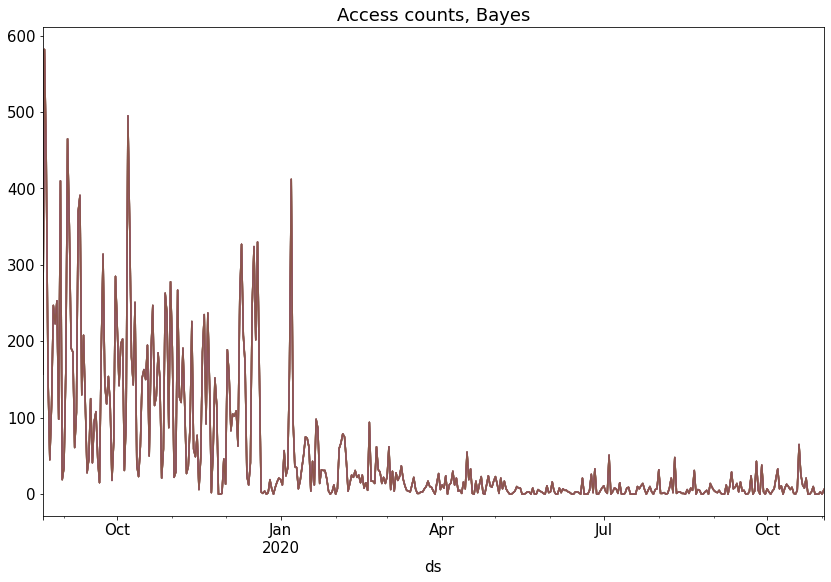

In [67]:
data_science[data_science.cohort_id == '34'].resample('D').count().plot(legend=False)
plt.title('Access counts, Bayes')
plt.show()

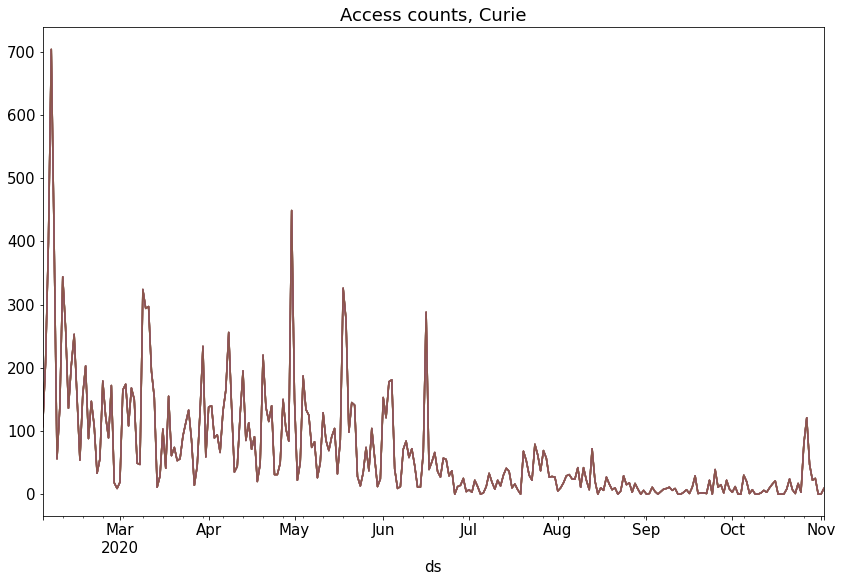

In [68]:
data_science[data_science.cohort_id == '55'].resample('D').count().plot(legend=False)
plt.title('Access counts, Curie')
plt.show()

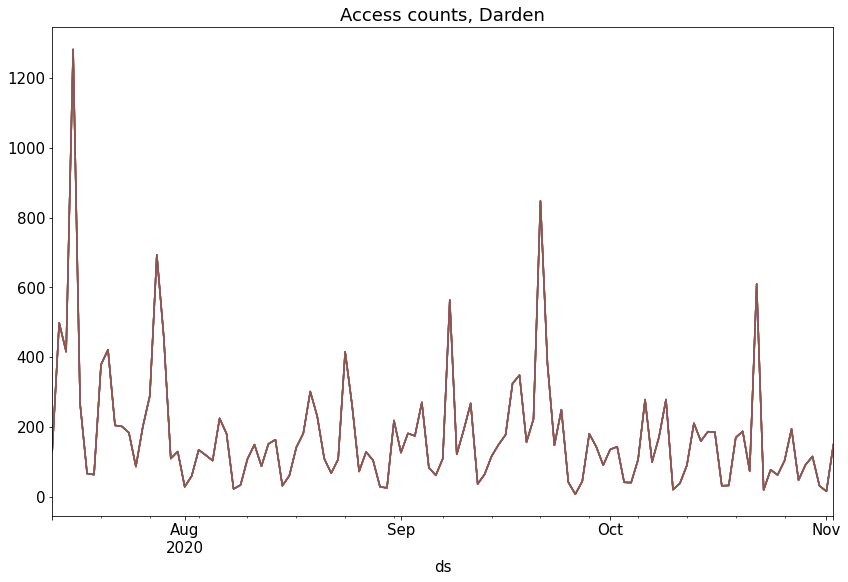

In [69]:
data_science[data_science.cohort_id == '59'].resample('D').count().plot(legend=False)
plt.title('Access counts, Darden')
plt.show()

In [72]:
for cohort in cohorts:
    print('Cohort', cohort)
    print(data_science[data_science.cohort_id == cohort].user_id.value_counts())
    print('---')

Cohort 30
Series([], Name: user_id, dtype: int64)
---
Cohort 34
485    2185
475    1999
476    1856
479    1836
478    1325
482    1303
471    1259
469    1238
473    1182
481    1072
358    1051
466    1045
480    1004
484    1001
483     717
468     637
472     631
474     559
467     515
470     419
477     413
487      16
650       7
Name: user_id, dtype: int64
---
Cohort 55
581    3061
576    1515
590    1478
584    1312
579    1220
582    1213
585    1115
580    1096
586     888
589     776
591     749
617     743
578     710
588     628
616     574
587     535
575     531
583     431
577     258
787       1
Name: user_id, dtype: int64
---
Cohort 59
685    2335
689    1512
698    1412
699    1336
688    1235
692    1226
681    1147
682    1008
691     931
678     904
684     788
680     784
268     759
696     753
687     670
695     662
686     604
690     567
694     481
739     458
693     321
683     148
781      83
783      52
780      43
785      29
697      12
679      10


In [153]:
for cohort in cohorts:
    print('Cohort', cohort)
    print(data_science[data_science.cohort_id == cohort].network.value_counts())
    print('---')

Cohort 30
Series([], Name: network, dtype: int64)
---
Cohort 34
97105     15793
76211       722
70226       683
6711        530
13650       499
          ...  
73163         1
24153         1
174197        1
174246        1
24227         1
Name: network, Length: 97, dtype: int64
---
Cohort 55
97105    4902
72190    2225
99126    1090
70112     854
64250     846
         ... 
7142        1
20936       1
16289       1
99203       1
6397        1
Name: network, Length: 68, dtype: int64
---
Cohort 59
9976      2328
13650     2279
6711      1885
968       1638
72181     1431
70125     1231
108239    1230
173174    1136
6854       986
70120      954
6669       931
76201      897
99132      694
162197     662
72177      575
2428       434
99203      175
192171     111
7515       107
184203      96
17258       64
986         55
24173       48
10448       45
104219      37
10777       34
70117       31
173123      25
76186       20
173149      18
10713       17
72191       16
173127      13
184

**Students with low number of curriculum access logs**

In [98]:
data_science[data_science.user_id == 487]

,request_method,user_id,cohort_id,ip,network,host
ds,,,,,,
2019-08-30 12:02:11,appendix/cli/1-intro,487,34,97.105.19.58,97105,1958
2019-08-30 12:11:10,appendix/cli/2-listing-files,487,34,97.105.19.58,97105,1958
2019-08-30 13:37:40,appendix/cli/0-overview,487,34,97.105.19.58,97105,1958
2019-08-30 13:37:58,appendix/cli-git-overview,487,34,97.105.19.58,97105,1958
2019-08-30 14:12:22,appendix/cli/3-file-paths,487,34,97.105.19.58,97105,1958
2019-08-30 14:19:45,appendix/cli/4-navigating-the-filesystem,487,34,97.105.19.58,97105,1958
2019-08-30 14:32:22,appendix/cli/5-creating-files-and-directories,487,34,97.105.19.58,97105,1958
2019-08-30 14:38:57,appendix/cli/4-navigating-the-filesystem,487,34,97.105.19.58,97105,1958
2019-08-30 14:59:46,appendix/cli/5-creating-files-and-directories,487,34,97.105.19.58,97105,1958


**Takeaways:** Student with user_id 487 in Bayes only ever accessed the appendix. IP ```97.105.19.58```.

In [99]:
response = reader.city('97.105.19.58')
print(response.country.iso_code)
print(response.country.name)
print(response.postal.code)
print(response.subdivisions.most_specific.name)
print(response.city.name)
print(response.location.latitude)
print(response.location.longitude)

US
United States
75243
Texas
Dallas
32.9103
-96.7283


It's someone in Dallas, so perhaps is not a student, but staff. IP doesn't have a bad reputation at least.

In [100]:
data_science[data_science.user_id == 650]

,request_method,user_id,cohort_id,ip,network,host
ds,,,,,,
2020-05-07 10:35:52,appendix/professional-development/virtual-meet...,650,34,70.123.225.30,70123,22530
2020-06-25 10:19:01,appendix/cli-git-overview,650,34,70.123.225.30,70123,22530
2020-06-25 10:20:00,appendix/ds-environment-setup,650,34,70.123.225.30,70123,22530
2020-07-03 15:15:21,11-nlp/3-acquire,650,34,70.123.225.30,70123,22530
2020-07-06 11:41:32,appendix/ds-environment-setup,650,34,70.123.225.30,70123,22530
2020-08-09 13:18:23,python/intro-to-matplotlib,650,34,70.123.225.30,70123,22530
2020-08-09 14:06:52,python/intro-to-matplotlib,650,34,70.123.225.30,70123,22530


What user 650 accesses seems a little random, so I'm going to investigate.

In [113]:
response = reader.city('70.123.225.30')
print(response.country.iso_code)
print(response.country.name)
print(response.postal.code)
print(response.subdivisions.most_specific.name)
print(response.city.name)
print(response.location.latitude)
print(response.location.longitude)

US
United States
78108
Texas
Cibolo
29.5738
-98.2292


> The IP Address 70.123.225.30 was found to have a negative reputation. Reasons for this assessment include:
> * The host has been observed sending spam in a format that is similar to snow shoe spamming techniques.
> * The host is unauthorized to send email directly to email servers.

In [114]:
data_science[data_science.user_id == 787]

,request_method,user_id,cohort_id,ip,network,host
ds,,,,,,
2020-10-29 22:08:03,appendix/interview_questions_students,787,55,99.126.113.140,99126,113140


No bad reputation found and since user 787 is just looking at interview questions once, that seems fairly benign.

In [132]:
data_science[data_science.user_id == 781].resample('D').sum()

,user_id
ds,
2020-10-26,6248
2020-10-27,14839
2020-10-28,3905
2020-10-29,10153
2020-10-30,5467
2020-10-31,3905
2020-11-01,3905
2020-11-02,16401


In [148]:
x = data_science['2020-10-26']
x[x.user_id == 781]

#x = data_science['2020-10-27']
#x[x.user_id == 781]

#x = data_science['2020-10-28']
#x[x.user_id == 781]

# Lots of time series and classification so far.

#x = data_science['2020-10-29']
#x[x.user_id == 781]

#x = data_science['2020-10-30']
#x[x.user_id == 781]

#x = data_science['2020-10-30']
#x[x.user_id == 781]

#x = data_science['2020-10-31']
#x[x.user_id == 781]

#x = data_science['2020-11-01']
#x[x.user_id == 781]

x = data_science['2020-11-02']
x[x.user_id == 781]

,request_method,user_id,cohort_id,ip,network,host
ds,,,,,,
2020-11-02 08:51:05,classification/overview,781,59,108.239.188.205,108239,188205
2020-11-02 08:51:05,classification/scale_features_or_not.svg,781,59,108.239.188.205,108239,188205
2020-11-02 08:51:07,anomaly-detection/overview,781,59,108.239.188.205,108239,188205
2020-11-02 08:51:07,anomaly-detection/AnomalyDetectionCartoon.jpeg,781,59,108.239.188.205,108239,188205
2020-11-02 09:25:40,classification/overview,781,59,108.239.188.205,108239,188205
2020-11-02 09:25:41,classification/scale_features_or_not.svg,781,59,108.239.188.205,108239,188205
2020-11-02 09:25:46,timeseries/modeling-lesson1,781,59,108.239.188.205,108239,188205
2020-11-02 10:46:05,sql/mysql-overview,781,59,108.239.188.205,108239,188205
2020-11-02 10:46:15,stats/correlation,781,59,108.239.188.205,108239,188205


**Takeaways:** User 781 isn't listed as having a bad reputation and looks like a real human student.

I notice that they usually go on the curriculum mostly just at 3 different times a day, once around 8:30am to 9:30am, and then again around lunch, and then between ~2/3pm and 4/5pm.

Perhaps this student doesn't usually do homework/reference the curriculum after class has ended for the day.

However it's likely this student's data is incomplete (probably split between different IP addresses/user_ids) because it doesn't begin until 10-26.

In [149]:
data_science[data_science.user_id == 783]

,request_method,user_id,cohort_id,ip,network,host
ds,,,,,,
2020-10-25 14:34:13,classification/overview,783,59,70.120.16.59,70120,1659
2020-10-25 14:34:13,classification/scale_features_or_not.svg,783,59,70.120.16.59,70120,1659
2020-10-25 14:34:16,timeseries/project,783,59,70.120.16.59,70120,1659
2020-10-25 14:36:54,timeseries/overview,783,59,70.120.16.59,70120,1659
2020-10-25 14:40:18,timeseries/acquire,783,59,70.120.16.59,70120,1659
2020-10-25 14:59:52,timeseries/working-with-time-series-data,783,59,70.120.16.59,70120,1659
2020-10-27 07:44:50,timeseries/prep,783,59,70.120.16.59,70120,1659
2020-10-27 07:49:46,timeseries/project,783,59,70.120.16.59,70120,1659
2020-10-27 07:49:50,timeseries/explore,783,59,70.120.16.59,70120,1659


This user's low number are also due to the date starting late, at 10-25.

In [150]:
data_science[data_science.user_id == 780]

,request_method,user_id,cohort_id,ip,network,host
ds,,,,,,
2020-10-22 14:21:19,timeseries/overview,780,59,99.132.128.255,99132,128255
2020-10-22 15:35:22,timeseries/acquire,780,59,99.132.128.255,99132,128255
2020-10-22 18:40:09,regression/acquire-and-prep,780,59,99.132.128.255,99132,128255
2020-10-22 18:41:01,regression/split-and-scale,780,59,99.132.128.255,99132,128255
2020-10-22 18:42:11,regression/explore,780,59,99.132.128.255,99132,128255
2020-10-22 18:43:55,regression/evaluate,780,59,99.132.128.255,99132,128255
2020-10-22 18:44:54,regression/feature-engineering,780,59,99.132.128.255,99132,128255
2020-10-22 18:47:04,regression/model,780,59,99.132.128.255,99132,128255
2020-10-22 18:47:40,regression/project,780,59,99.132.128.255,99132,128255


This user's low number are also due to the date starting late, at 10-22.

In [151]:
data_science[data_science.user_id == 785]

,request_method,user_id,cohort_id,ip,network,host
ds,,,,,,
2020-10-26 14:35:01,timeseries/acquire,785,59,72.181.127.233,72181,127233
2020-10-27 09:13:52,working-with-time-series-data,785,59,72.181.127.233,72181,127233
2020-10-27 09:13:55,working-with-time-series-data,785,59,72.181.127.233,72181,127233
2020-10-27 09:13:57,working-with-time-series-data,785,59,72.181.127.233,72181,127233
2020-10-27 09:14:02,working-with-time-series-data,785,59,72.181.127.233,72181,127233
2020-10-27 09:14:14,sql/mysql-overview,785,59,72.181.127.233,72181,127233
2020-10-27 09:14:14,classification/overview,785,59,72.181.127.233,72181,127233
2020-10-27 09:14:14,classification/scale_features_or_not.svg,785,59,72.181.127.233,72181,127233
2020-10-27 09:14:20,timeseries/overview,785,59,72.181.127.233,72181,127233


This user's low number are also due to the date starting late, at 10-22.

In [152]:
data_science[data_science.user_id == 697]

,request_method,user_id,cohort_id,ip,network,host
ds,,,,,,
2020-07-13 15:20:48,3-sql/1-mysql-overview,697,59,136.50.70.27,13650,7027
2020-07-13 15:20:50,1-fundamentals/1.1-intro-to-data-science,697,59,136.50.70.27,13650,7027
2020-07-13 15:20:50,1-fundamentals/modern-data-scientist.jpg,697,59,136.50.70.27,13650,7027
2020-07-13 15:20:50,1-fundamentals/AI-ML-DL-timeline.jpg,697,59,136.50.70.27,13650,7027
2020-07-13 15:20:59,1-fundamentals/1.2-data-science-pipeline,697,59,136.50.70.27,13650,7027
2020-07-13 15:20:59,1-fundamentals/DataToAction_v2.jpg,697,59,136.50.70.27,13650,7027
2020-07-13 15:21:01,1-fundamentals/1.1-intro-to-data-science,697,59,136.50.70.27,13650,7027
2020-07-13 15:21:02,1-fundamentals/AI-ML-DL-timeline.jpg,697,59,136.50.70.27,13650,7027
2020-07-13 15:21:02,1-fundamentals/modern-data-scientist.jpg,697,59,136.50.70.27,13650,7027


User 697 only accessed the curriculum on the first day of class for Darden. Looking at the access times and how they are in quick succession, I wonder if this a bot that tried to hide in all of the first-day-of-class traffic.

I looked up the IP address and the search returned this:
    
> The IP Address 136.50.70.27 was found to have a negative reputation. Reasons for this assessment include:
> 
> * The host has been observed sending spam in a format that is similar to snow shoe spamming techniques.
> * The host is unauthorized to send email directly to email servers.

I can add this IP to my list of suspicious IPs.

In [156]:
data_science[data_science.user_id == 679]

,request_method,user_id,cohort_id,ip,network,host
ds,,,,,,
2020-07-13 14:39:21,13-advanced-topics/1-tidy-data,679,59,24.28.146.155,2428,146155
2020-07-13 14:39:36,1-fundamentals/1.1-intro-to-data-science,679,59,24.28.146.155,2428,146155
2020-07-13 14:39:37,1-fundamentals/AI-ML-DL-timeline.jpg,679,59,24.28.146.155,2428,146155
2020-07-13 14:39:37,1-fundamentals/modern-data-scientist.jpg,679,59,24.28.146.155,2428,146155
2020-07-13 15:49:31,1-fundamentals/1.1-intro-to-data-science,679,59,24.28.146.155,2428,146155
2020-07-13 15:49:32,1-fundamentals/modern-data-scientist.jpg,679,59,24.28.146.155,2428,146155
2020-07-13 15:49:32,1-fundamentals/AI-ML-DL-timeline.jpg,679,59,24.28.146.155,2428,146155
2020-07-14 08:05:15,1-fundamentals/1.1-intro-to-data-science,679,59,24.28.146.155,2428,146155
2020-07-14 08:05:15,1-fundamentals/AI-ML-DL-timeline.jpg,679,59,24.28.146.155,2428,146155


This one looks like it could one of the pieces of the same snowshoe technique as user 697.

I looked it up and that was confirmed.

I will add it to the suspicious IPs.

# Next step: Make acquire.py, prepare.py, preprocess.py, explore.py

In [269]:
city_plot_df = data_science.groupby('city').filter(lambda x : len(x)>100)
city_plot_df.city.nunique()

16

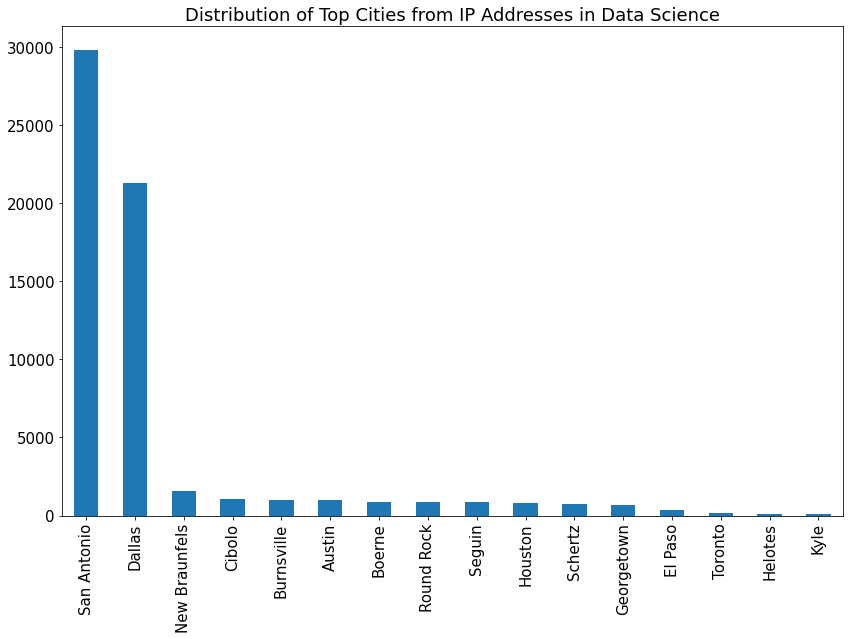

In [270]:
city_plot_df['city'].value_counts().plot(kind='bar')
plt.title('Distribution of Top Cities from IP Addresses in Data Science')
plt.show()

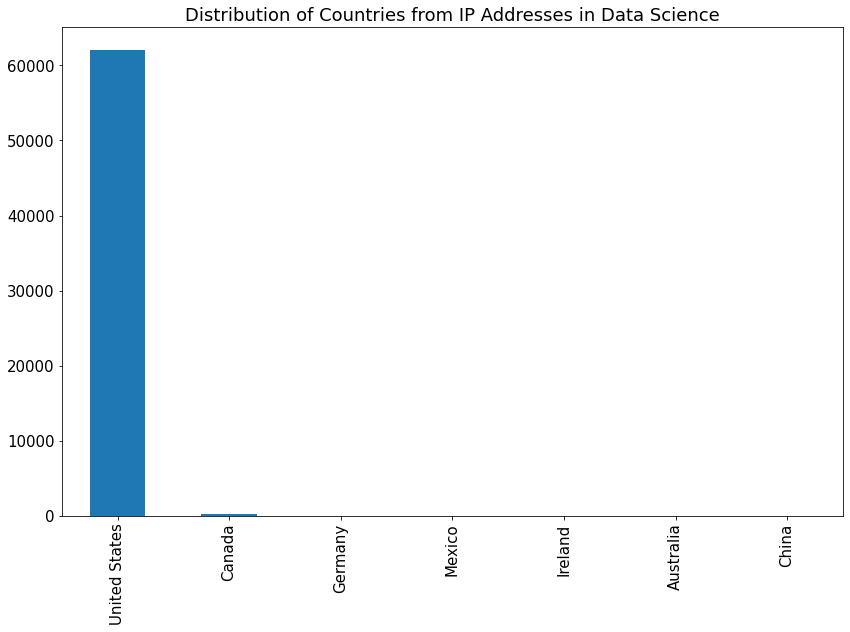

In [271]:
data_science['country'].value_counts().plot(kind='bar')
plt.title('Distribution of Countries from IP Addresses in Data Science')
plt.show()

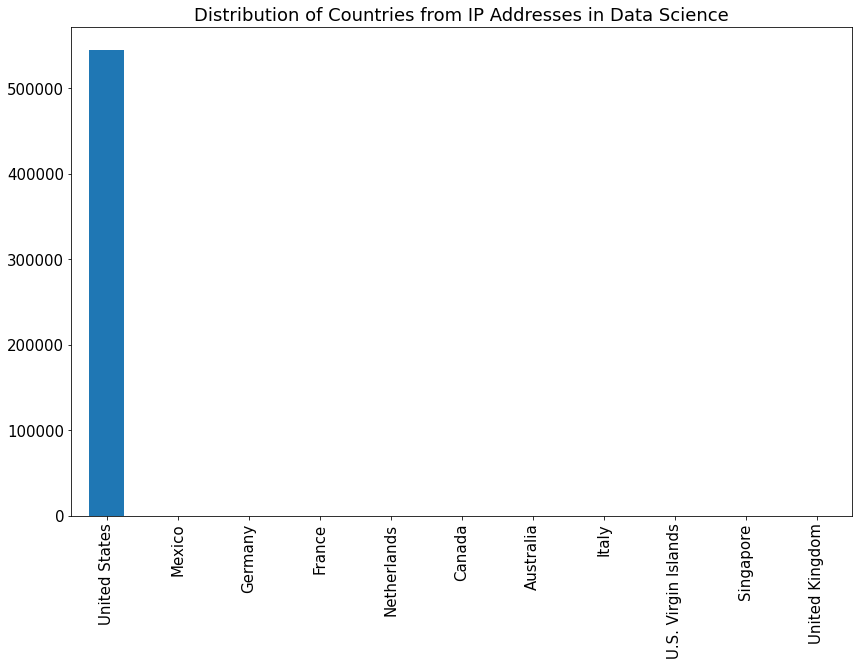

In [272]:
web_dev['country'].value_counts().plot(kind='bar')
plt.title('Distribution of Countries from IP Addresses in Data Science')
plt.show()